# CWN general features

In [1]:
# Setting paths
import sys,os
import pathlib
sys.path.insert(0,os.path.expanduser('~/caryocar'))
sys.path.insert(0,os.path.abspath('..'))

In [2]:
# Building the networks from data
from setupmodels import *

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import scipy as scp 

import matplotlib.pyplot as plt

from collections import Counter

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-paper')
sns.set_color_codes('deep')

%matplotlib inline

In [4]:
# plot style params
sns.set_color_codes('deep')
plt.rc('figure', figsize=(8,5))

empty_circle={'markerfacecolor':'none','markeredgewidth':1.3,'ms':10,'marker':'o','ls':''}
xes={'markerfacecolor':'none','markeredgewidth':1.3,'ms':10,'marker':'x','ls':''}

---

### General info

In [5]:
print(nx.info(cwn))

Name: 
Type: CoworkingNetwork
Number of nodes: 6768
Number of edges: 10391
Average degree:   3.0706


In [6]:
num_cols = cwn.number_of_nodes()

* How many singleton collaborators (Not a single collaboration, $k=0$) ?

In [7]:
num_singletons = len(set(nx.isolates(cwn)))
num_singletons

2673

In [8]:
"Percentage of singletons: {:.2%}".format(num_singletons/cwn.number_of_nodes())

'Percentage of singletons: 39.49%'

In [9]:
print("Overall density of the CWN network: {:.5f}".format(nx.density(cwn)))

Overall density of the CWN network: 0.00045


---

### Connected components

In [10]:
sgs = list(nx.connected_component_subgraphs(cwn))
sgs = sorted(sgs,key=lambda g: g.number_of_nodes(),reverse=True)

In [11]:
giantComp = sgs[0]
connectedComps = sgs[1:]

In [12]:
print("Number of components: {}".format(len(sgs)))

Number of components: 2991


In [13]:
print("Size of the giant component: {} nodes, {:.2%}".format( 
    giantComp.number_of_nodes(),
    giantComp.number_of_nodes()/cwn.number_of_nodes()
))

Size of the giant component: 3114 nodes, 46.01%


In [14]:
print("Density of the giant component: {:.5f}".format(nx.density(giantComp)))

Density of the giant component: 0.00195


In [15]:
print("Sizes of the top-10 connected components (excluding c1):\n"+\
"\n".join( ["\tConnected comp c{}: {} nodes".format(i+2, sg.number_of_nodes()) for i,sg in enumerate(connectedComps[:10])]))


Sizes of the top-10 connected components (excluding c1):
	Connected comp c2: 59 nodes
	Connected comp c3: 20 nodes
	Connected comp c4: 16 nodes
	Connected comp c5: 15 nodes
	Connected comp c6: 10 nodes
	Connected comp c7: 9 nodes
	Connected comp c8: 9 nodes
	Connected comp c9: 9 nodes
	Connected comp c10: 8 nodes
	Connected comp c11: 8 nodes


In [16]:
print("Average size of isolated components: {:.3}".format( np.mean([ sg.number_of_nodes() for sg in connectedComps ]) ))

Average size of isolated components: 1.22


* All singletons are an isolated component (this is why there are so many of them)

In [17]:
print("Number of non-singleton isolated components: {}".format( sum( 1 for sg in connectedComps if sg.number_of_nodes()>1 ) ))

Number of non-singleton isolated components: 317


#### Singleton collectors

How many singleton collectors?

In [18]:
isolated_nodes = [ list(comp.nodes)[0] for comp in connectedComps if len(comp.nodes)==1 ]

In [19]:
len(isolated_nodes)

2673

How many records by singleton collectors have been recorded in Brazil?

In [20]:
isolated_nodes_occs = set( ix for i in isolated_nodes for ix in ni[i])

In [21]:
occs.loc[isolated_nodes_occs]['countryCode'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')[:5]

BR    81.08%
ID     2.73%
US     2.62%
AU     1.91%
PG     1.48%
Name: countryCode, dtype: object

Who are the most important of these?

In [22]:
singleton_nrecs = sorted([ (n,len(ni[n])) for n in isolated_nodes ], key=lambda x: x[1], reverse=True)

In [23]:
# collector, num of recs
singleton_nrecs[:10]

[('leite,alta', 2757),
 ('touw,a', 375),
 ('schiffner,v', 283),
 ('oliveira,e', 252),
 ('coelho,gsf', 227),
 ('rocha,mal', 165),
 ('aquino,ppu', 155),
 ('pinto,rnm', 144),
 ('silva,nf', 133),
 ('nitikman,lz', 131)]

*'leite,alta'* is by far the one with most records. What is the proportion of records collected by *leite,alta*, considering all contributions by singleton collectors?

In [24]:
"{:.2%}".format(singleton_nrecs[0][1] / sum(list(zip(*singleton_nrecs))[1]))

'18.14%'

How many records do singleton collectors have? This also seems to follow a power law!

In [25]:
# logarithmic binning
bins = np.logspace(np.log10(1),np.log10(2**13),num=14)
vals = [ len(ni[n]) for n in isolated_nodes ]

In [26]:
x,y = zip(*Counter(vals).items())

Text(0,0.5,'Num of Singleton Collectors')

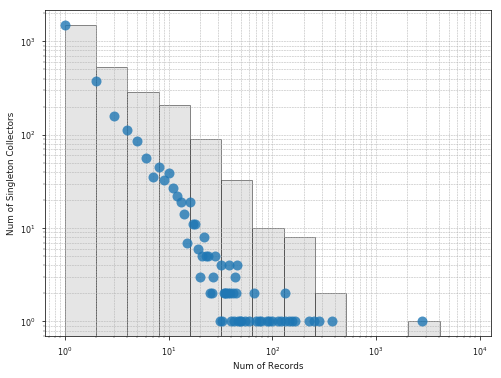

In [27]:
plt.figure(figsize=(8,6))
plt.hist(vals,bins=bins, density=False, alpha=0.5, color='.8', linewidth=1, edgecolor='k')
plt.plot(x,y,marker='o',ls='', ms=10, alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both',ls='--', lw=0.5)
plt.xlabel('Num of Records')
plt.ylabel('Num of Singleton Collectors')

---

### Team Sizes

What is the average team size?

In [28]:
# avg team size
occs['recordedBy_atomized'].apply(len).mean()

1.7274678393279075

Let's visualize **team size** vs **percentage of records** 

In [29]:
x,y = zip( *occs['recordedBy_atomized'].apply(len).value_counts().items())

In [30]:
y=[ i/sum(y) for i in y ]

In [31]:
#Transform y
y_transf = list(map(lambda x: np.log10(x), y))

# fit with transformed y
f = lambda x,b0,b1: b0+b1*x
(b0,b1),cov = scp.optimize.curve_fit(f, x[:-1], y_transf[:-1]) # The last point is not used for fitting!

In [32]:
b0,b1

(0.15565328522708521, -0.37717744613512005)

Text(0,0.5,'Percentage of Records')

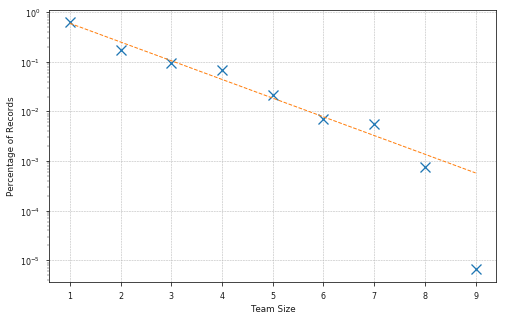

In [33]:
# Plot figure in log-lin scale

plt.figure(figsize=(8,5))
plt.plot(x,y,**xes)
plt.plot(x,[ (10**(b0+b1*i)) for i in x ], ls='--',lw=1)

plt.yscale('log')
plt.grid(linewidth=0.5, ls='--',color='.7')
plt.xlabel('Team Size')
plt.ylabel('Percentage of Records')
#plt.savefig('team_sizes_pcts.pdf', dpi=92, bbox_inches='tight')

* A high percentage ($63\%$) of records with team size = 1;
* A single record with team size = 9 (this was not used to fit the line in figure above);
* Records percentage decays approximately in a exponentially decreasing function;

Only one record with $team\_size>8$. It appears the names string has been truncated.

In [34]:
pd.options.display.max_colwidth=100

In [35]:
occs[occs['recordedBy_atomized'].apply(len)==9]['recordedBy'].iloc[0]

'Faria, JEQ; Proença, C; Concha, C; Reis, PA; Rosa, PO; Izetti, C; Mello, TRB; Oku, W; Mende'

Collectors names strings from records with $team\_size = 8$ have also been truncated.

In [36]:
occs[occs['recordedBy_atomized'].apply(len)==8]['recordedBy'].value_counts()

Haidar, RF; Matos, MQ; Fagg, CW; Felfili, JM; Mendonça, RC; Proença, CEB; Farias, R; Rodrig      34
Matos, MQ; Haidar, RF; Fagg, CW; Felfili, JM; Mendonça, RC; Proença, CEB; Farias, R; Rodri       31
Faria, JEQ; Câmara, PEAS; Costa, DP; Martins, DS; Amorim, PRF; Sousa, RV; Gonzaga, RMO; Car      29
Faria, JEQ; Campos, LZO; Ibrahim, M; Martins, RC; Caires, CS; Meneguzzo, TEC; Souza, LF; Nu      13
Martins, DS; Câmara, PEAS; Amorim, PRF; Costa, DP; Faria, JEQ; Carvalho, AM; Gonzaga, RMO; S      3
Henderson, A; Cid, CA; Lima, J; Alves, J; Rickson, F; Parker, D; Aulino, O; Rodrigues, K          2
Harley, RM; Giulietti, AM; Stannard, BL; Hind, DJN; Kameyama, C; Prado, J; Rudall, P; Simão       1
Walter, BMT; Silva, GP; Xavier, S; Rocha, F; Santos, H; Silva, S; Tavares, G; Mendonça, R         1
Ratter, JA; Bridgewater, S; Cardoso, E; Fonseca, J; Lima, V; Passon, L; Santos, RR; Sanaiot       1
Walter, BMT; Silva, GP; Xavier, S; Costa F.; Santos H.; Silva, S; Tavares, G; Mendonça, RC        1


Plotting inset

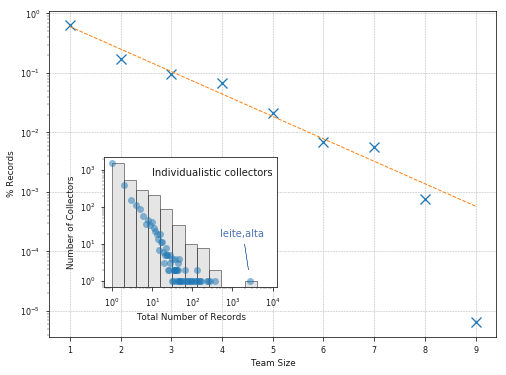

In [42]:
fig, ax1 = plt.subplots(figsize=(8,6))

# Plot 1
x,y = zip( *occs['recordedBy_atomized'].apply(len).value_counts().items())
y=[ i/sum(y) for i in y ]
y_transf = list(map(lambda x: np.log10(x), y))
f = lambda x,b0,b1: b0+b1*x
(b0,b1),cov = scp.optimize.curve_fit(f, x[:-1], y_transf[:-1]) # The last point is not used for fitting!
ax1.plot(x,y,**xes)
ax1.plot(x,[ (10**(b0+b1*i)) for i in x ], ls='--',lw=1)
ax1.semilogy()
ax1.set_xlabel('Team Size')
ax1.set_ylabel('% Records')
ax1.grid(linewidth=0.5, ls='--',color='.7')

# Inset plot
ax2 = fig.add_axes([0.22,0.24,0.3,0.3])
bins = np.logspace(np.log10(1),np.log10(2**13),num=14)
vals = [ len(ni[n]) for n in isolated_nodes ]
x,y = zip(*Counter(vals).items())
ax2.hist(vals,bins=bins, density=False, alpha=0.5, color='.8', linewidth=1, edgecolor='k')
ax2.plot(x,y,marker='o',ls='', ms=7, alpha=0.5)
ax2.loglog()
ax2.set_xlabel('Total Number of Records')
ax2.set_ylabel('Number of Collectors')
ax2.text(1e1,7e2,'Individualistic collectors')
ax2.arrow(x=2e3,y=1e1,dx=(2.5e3-2e3),dy=(2e0-1e1), lw=0.5, fc='b', ec='b')
ax2.text(.5e3,1.6e1,'leite,alta',color='b')

plt.savefig('team_sizes.pdf', dpi=92, bbox_inches='tight')

---

### Most central collectors

Average degrees for *(i)* the entire network; *(ii)* the giant component; *(iii)* all connected components excluding $c_1$.

In [38]:
print("Overall average degree: {:.2f}".format(sum( k for n,k in list(cwn.degree()) )/cwn.number_of_nodes()))

Overall average degree: 3.07


In [39]:
print("Giant component average degree: {:.2f}".format( sum(k for n,k in list(giantComp.degree()))/giantComp.number_of_nodes() ))

Giant component average degree: 6.08


In [40]:
num_nodes = sum( 1 for comp in connectedComps for node in comp.nodes() )
print("Average degree <k> for all connected components (excluding c1): {:.2f}".format(
    sum( cwn.degree(node) for comp in connectedComps for node in comp.nodes() )/num_nodes))

Average degree <k> for all connected components (excluding c1): 0.51


Create a latex table: top-20 collectors (ordered by degree $k$)

In [42]:
def getNumCollabRecords(col,pct=False):
    o=occs.loc[ni[col]]
    o_collab = o[o['recordedBy_atomized'].apply(len)>1]
    if pct:
        return o_collab.shape[0]/o.shape[0]
    return o_collab.shape[0]


# Make table data
table_data = [  (  col, 
                   d['count'],
                   getNumCollabRecords(col,pct=True),
                   cwn.degree(col), 
                   cwn.degree(col,weight='weight_hyperbolic') ) for col,d in cwn.nodes(data=True)]

In [43]:
occs.loc[ni['irwin,hs']]['recordedBy_atomized'].apply(len).value_counts()

1    11896
3     2829
4     1778
2      713
5      564
6      285
Name: recordedBy_atomized, dtype: int64

In [44]:
table_data = sorted(table_data,key=lambda x: x[4],reverse=True)
table_data[:20]

[('irwin,hs', 18065, 0.341489067257127, 39, 5696.000000000027),
 ('proenca,ceb', 4803, 0.8825733916302311, 218, 4203.6666666666615),
 ('faria,jeq', 4687, 0.8291071809077349, 117, 3881.000000000021),
 ('souza,rr', 3885, 0.9927965011577051, 37, 3835.500000000027),
 ('santos,rrb', 3587, 0.9445218845832172, 41, 3382.2500000000327),
 ('munhoz,cbr', 3191, 0.8282670009401442, 109, 2493.1666666666656),
 ('zanatta,mrv', 2364, 0.9576988155668359, 50, 2264.0000000000173),
 ('castelobranco,cw', 2256, 1.0, 1, 2256.0),
 ('grando,jv', 2256, 1.0, 1, 2256.0),
 ('eiten,g', 3046, 0.6138451443569554, 33, 1865.5),
 ('amaral,ag', 1825, 0.9950684931506849, 37, 1814.9999999999977),
 ('projetobiodiversidadebp', 1780, 1.0, 19, 1779.9999999999977),
 ('mendes,vc', 1696, 0.9994103773584906, 89, 1695.0000000000014),
 ('fonseca,sf', 1610, 0.999379652605459, 18, 1606.9999999999802),
 ('camara,peas', 2076, 0.7976878612716763, 47, 1485.9999999999998),
 ('harley,rm', 2564, 0.6599063962558502, 90, 1455.833333333333),
 ('

In [45]:
# col, num_recs, k, k_w (hyperbolic), collaborativeness
table = ""
for row in table_data[:20]:
    table += '{} & {} & {:.1%} & {} & {:.1f} \\\\\n'.format(*row).replace('%','')

print(table)

irwin,hs & 18065 & 34.1 & 39 & 5696.0 \\
proenca,ceb & 4803 & 88.3 & 218 & 4203.7 \\
faria,jeq & 4687 & 82.9 & 117 & 3881.0 \\
souza,rr & 3885 & 99.3 & 37 & 3835.5 \\
santos,rrb & 3587 & 94.5 & 41 & 3382.3 \\
munhoz,cbr & 3191 & 82.8 & 109 & 2493.2 \\
zanatta,mrv & 2364 & 95.8 & 50 & 2264.0 \\
castelobranco,cw & 2256 & 100.0 & 1 & 2256.0 \\
grando,jv & 2256 & 100.0 & 1 & 2256.0 \\
eiten,g & 3046 & 61.4 & 33 & 1865.5 \\
amaral,ag & 1825 & 99.5 & 37 & 1815.0 \\
projetobiodiversidadebp & 1780 & 100.0 & 19 & 1780.0 \\
mendes,vc & 1696 & 99.9 & 89 & 1695.0 \\
fonseca,sf & 1610 & 99.9 & 18 & 1607.0 \\
camara,peas & 2076 & 79.8 & 47 & 1486.0 \\
harley,rm & 2564 & 66.0 & 90 & 1455.8 \\
carvalhosilva,m & 1635 & 98.5 & 58 & 1436.0 \\
eiten,lt & 1262 & 99.6 & 14 & 1256.5 \\
mello,trb & 1247 & 100.0 & 21 & 1247.0 \\
soares,aer & 1557 & 73.0 & 29 & 1135.0 \\



*Ratter,JA* is at the $21th$ position at the $k_w$-sorted rank, with a total of $111$ collaborative records.

In [49]:
[ (i+1,d[0],d[3]) for i ,d in enumerate(sorted(table_data,key=lambda x: x[4],reverse=True)) if d[0]=='ratter,ja' ]

[(21, 'ratter,ja', 111)]

Irwin,HS is at the 43th position in the k-sorted rank, with a total of 6169 collaborative records.

In [115]:
[ (i+1,d[0]) for i ,d in enumerate(sorted(table_data,key=lambda x: x[3],reverse=True)) if d[0]=='irwin,hs' ]

[(43, 'irwin,hs')]

In [132]:
num_coll_recs = lambda col: sum(occs.loc[ni[col]]['recordedBy_atomized'].apply(len).apply(lambda x: x>1))

In [136]:
num_coll_recs('irwin,hs')

6169

In [140]:
l = [ (c,num_coll_recs(c)) for c in cwn.nodes() ]

In [142]:
sorted(l,key=lambda x: x[1],reverse=True)

[('irwin,hs', 6169),
 ('proenca,ceb', 4239),
 ('faria,jeq', 3891),
 ('souza,rr', 3859),
 ('santos,rrb', 3388),
 ('munhoz,cbr', 2643),
 ('zanatta,mrv', 2264),
 ('castelobranco,cw', 2256),
 ('grando,jv', 2256),
 ('eiten,g', 1871),
 ('amaral,ag', 1816),
 ('projetobiodiversidadebp', 1780),
 ('mendes,vc', 1695),
 ('harley,rm', 1692),
 ('camara,peas', 1656),
 ('fonseca,sf', 1611),
 ('carvalhosilva,m', 1610),
 ('anderson,wr', 1277),
 ('eiten,lt', 1257),
 ('mello,trb', 1247),
 ('ratter,ja', 1229),
 ('soares,aer', 1136),
 ('amorim,prf', 1068),
 ('ramos,j', 1065),
 ('eugenio,cuo', 1063),
 ('concha,c', 1010),
 ('onishi,e', 990),
 ('souza,rv', 981),
 ('silva,js', 886),
 ('grearjunior,jw', 883),
 ('soares-silva,lh', 878),
 ('castro,bm', 869),
 ('villarroel,d', 834),
 ('faria,ala', 830),
 ('stieber,mt', 813),
 ('belem,rp', 788),
 ('caires,cs', 786),
 ('simon,mf', 769),
 ('dantas,ts', 765),
 ('kirkbride-junior,jh', 757),
 ('emmert,p', 754),
 ('smith,gm', 721),
 ('maxwell,hh', 710),
 ('wasshausen,dc',

In [148]:
4803/18065

0.2658732355383338

In [145]:
sorted(table_data,key=lambda x: x[3],reverse=True)

[('proenca,ceb', 4803, 0.8825733916302311, 218, 4203.6666666666615),
 ('faria,jeq', 4687, 0.8291071809077349, 117, 3881.000000000021),
 ('ratter,ja', 4728, 0.2599407783417936, 111, 1084.9166666666672),
 ('munhoz,cbr', 3191, 0.8282670009401442, 109, 2493.1666666666656),
 ('silva,ma', 823, 0.5735115431348724, 93, 403.59999999999997),
 ('oliveira,rc', 723, 0.8867667121418826, 92, 595.2499999999998),
 ('harley,rm', 2564, 0.6599063962558502, 90, 1455.833333333333),
 ('mendes,vc', 1696, 0.9994103773584906, 89, 1695.0000000000014),
 ('souza,vc', 505, 0.5603960396039604, 89, 237.61666666666667),
 ('carvalho,avm', 884, 0.746606334841629, 88, 651.5),
 ('walter,bmt', 709, 0.5063469675599436, 80, 296.08333333333326),
 ('mendonca,rc', 1162, 0.536144578313253, 76, 603.7500000000001),
 ('franca,f', 538, 0.738404452690167, 72, 389.6666666666663),
 ('melo,e', 682, 0.5967741935483871, 65, 378.66666666666634),
 ('martins,rc', 715, 0.9286713286713286, 63, 664.0000000000001),
 ('silva,gp', 266, 0.402255639

#### Plot: $k$ and $k_w$ top-10 ranks

In [44]:
#cols = set( c for c,k in rank_cols_k[:10] ) | set( c for c,k in rank_cols_kw[:10] )
#data=list(zip(*[ (col, dict(rank_cols_k)[col], dict(rank_cols_kw)[col] ) for col in cols ]))

NameError: name 'data' is not defined

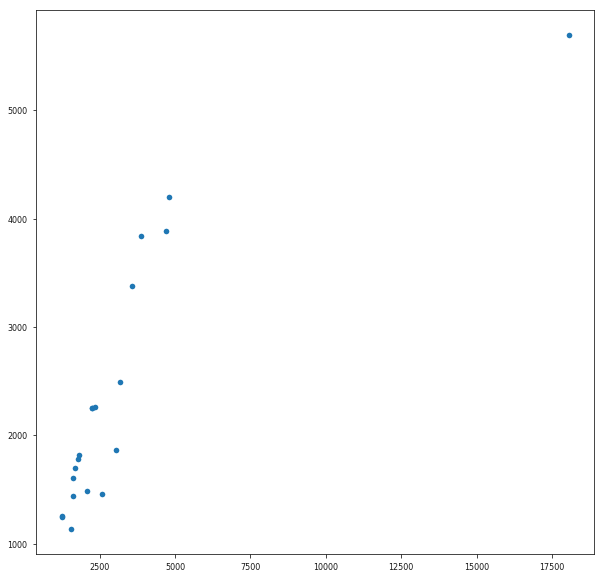

In [45]:
t,x,y = list(zip(*[ (col,nrecs,kw) for col,nrecs,pctcollab,k,kw in table_data[:20]]))

plt.figure(figsize=(10,10))
plt.plot(x,y,'o',label='c')

for t,x,y in zip(*data):
    plt.annotate(t, xy=(x,y),xytext=(10, 0),textcoords='offset points',
                family='sans-serif', fontsize=14, color='darkslategrey')


#plt.xlabel('# distinct collaborators ($k$)')
#plt.ylabel('$k_w$ (Hyperbolic weighting)')
plt.xscale('log')
plt.yscale('log')

* If we compare both rankings, only 3 collectors from 10 are shared

In [ ]:
set([ i[0] for i in top10_cols_k]) & set([ i[0] for i in top10_cols_kw ])

In [110]:
"Position of 'irwin,hs' in the rank k: {}th, with k={}".format(
    *[ (i+1,k) for i,(c,k) in enumerate(rank_cols_k) if c=='irwin,hs'][0] )

NameError: name 'rank_cols_k' is not defined

In [ ]:
"Position of 'ratter,ja' in the rank kw: {}th, with kw={}".format(
    *[ (i+1,k) for i,(c,k) in enumerate(rank_cols_kw) if c=='ratter,ja' ][0])

---

### Assortativity

In [46]:
# According to Newman 2003 - Mixing patterns in networks (eq21)
nx.assortativity.degree_assortativity_coefficient(cwn)


-0.0034149148149912904

In [47]:
nx.assortativity.degree_assortativity_coefficient( giantComp )

-0.03084341135155517

In [48]:
nx.write_gexf(cwn,'./g.gexf')

KeyError: <class 'NoneType'>

In [ ]:
!gephi g.gexf

In [ ]:
nx.set_edge_attributes(cwn,'','taxons')

In [ ]:
nx.write_gexf(cwn,'./g.gexf')

In [154]:
betw = nx.algorithms.centrality.betweenness_centrality(giantComp)

In [163]:
sorted([ (col,score) for col,score in betw.items() ], key=lambda x:x[1], reverse=True)

[('proenca,ceb', 0.1545496259269382),
 ('carvalho,avm', 0.08493272133667211),
 ('munhoz,cbr', 0.0837586662621276),
 ('souza,vc', 0.07356828623300529),
 ('harley,rm', 0.06717711434082323),
 ('faria,jeq', 0.0629497745584151),
 ('ratter,ja', 0.05872364542505854),
 ('oliveira,rc', 0.05147277787393332),
 ('silva,ma', 0.047435265807793996),
 ('cordeiro,i', 0.04017707312376996),
 ('walter,bmt', 0.036911710578415385),
 ('goncalves,eg', 0.03639170963092284),
 ('franca,f', 0.03477085428301387),
 ('hatschbach,g', 0.028692286898026522),
 ('oliveira,ms', 0.028450438462591345),
 ('carvalhosilva,m', 0.028395016673426615),
 ('silva,gp', 0.027095019201132844),
 ('mendes,vc', 0.027005351520871097),
 ('forzza,rc', 0.025491981702996987),
 ('silva,js', 0.02445840391740027),
 ('heringer,ep', 0.023805226519268755),
 ('jardim,jg', 0.02375691337559364),
 ('melo,e', 0.023705086093169413),
 ('silva,jm', 0.022533076426092154),
 ('novelino,rf', 0.022312898826981963),
 ('camara,peas', 0.021638009517699026),
 ('lima

In [165]:
occs[occs['recordedBy_atomized'].apply(lambda x: 'Faria' in str(x) and 'Zanatta' in str(x))]

,rightsHolder,recordedBy,occurrenceRemarks,eventDate,countryCode,stateProvince,scientificName,kingdom,phylum,class,order,family,genus,taxonRank,species,repatriated,recordedBy_atomized
44495,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV; Moreira, ALC; Paz, JRL",Subarbusto prostrado com inflorescência amarela e flores amarelas claras; Cerrado sensu stricto,2015-12-03T01:00Z,BR,Distrito Federal,Palicourea coriacea (Cham.) K.Schum.,Plantae,Tracheophyta,Magnoliopsida,Gentianales,Rubiaceae,Palicourea,SPECIES,Palicourea coriacea,False,"[Faria, JEQ, Zanatta, MRV, Moreira, ALC, Paz, JRL]"
44501,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV","Subarbusto ca. 0,5 m de altura, botões florais verdes; Cerrado sensu stricto em rebrota após que...",2015-12-03T01:00Z,BR,Distrito Federal,Psidium australe Cambess.,Plantae,Tracheophyta,Magnoliopsida,Myrtales,Myrtaceae,Psidium,SPECIES,Psidium australe,False,"[Faria, JEQ, Zanatta, MRV]"
44540,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV","Subarbusto ca. 0,4 m de altura, flores rosas; Cerrado sensu stricto",2015-12-03T01:00Z,BR,Distrito Federal,Cuphea spermacoce St.-Hil.,Plantae,Tracheophyta,Magnoliopsida,Myrtales,Lythraceae,Cuphea,SPECIES,Cuphea spermacoce,False,"[Faria, JEQ, Zanatta, MRV]"
44565,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV; Moreira, ALC; Paz, JRL","Árvore ca. 5 m de altura, botões florais verdes; Mata de galeria",2015-12-03T01:00Z,BR,Distrito Federal,Myrcia fenzliana O.Berg,Plantae,Tracheophyta,Magnoliopsida,Myrtales,Myrtaceae,Myrcia,SPECIES,Myrcia fenzliana,False,"[Faria, JEQ, Zanatta, MRV, Moreira, ALC, Paz, JRL]"
44567,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV","Subarbusto ca. 0,6 m de altura, folha fortemente discolor, verde na adaxial e marrom na abaxial,...",2015-12-03T01:00Z,BR,Distrito Federal,Lessingianthus erythrophilus (DC.) H.Rob.,Plantae,Tracheophyta,Magnoliopsida,Asterales,Asteraceae,Lessingianthus,SPECIES,Lessingianthus erythrophilus,False,"[Faria, JEQ, Zanatta, MRV]"
44572,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV; Moreira, ALC; Paz, JRL","Arbusto ca. 1,3 m de altura, frutos imaturos cinéreos; Cerrado sensu stricto",2015-12-03T01:00Z,BR,Distrito Federal,Psidium grandifolium Mart. ex DC.,Plantae,Tracheophyta,Magnoliopsida,Myrtales,Myrtaceae,Psidium,SPECIES,Psidium grandifolium,False,"[Faria, JEQ, Zanatta, MRV, Moreira, ALC, Paz, JRL]"
44573,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV","Erva 0,8 m; frutos marrons claros; Cerrado sensu stricto em rebrota após queimada",2015-12-03T01:00Z,BR,Distrito Federal,Anthaenantia lanata (Kunth) Benth.,Plantae,Tracheophyta,Liliopsida,Poales,Poaceae,Anthaenantia,SPECIES,Anthaenantia lanata,False,"[Faria, JEQ, Zanatta, MRV]"
44582,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV; Moreira, ALC; Paz, JRL","Árvore ca. 3,5 m de altura, flores amarelas; Cerrado sensu stricto",2015-12-03T01:00Z,BR,Distrito Federal,Vochysia tucanorum Mart.,Plantae,Tracheophyta,Magnoliopsida,Myrtales,Vochysiaceae,Vochysia,SPECIES,Vochysia tucanorum,False,"[Faria, JEQ, Zanatta, MRV, Moreira, ALC, Paz, JRL]"
44606,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV","Erva 0,5m; frutos cremes; Cerrado sensu stricto em rebrota após queimada",2015-12-03T01:00Z,BR,Distrito Federal,Paspalum ammodes Trin.,Plantae,Tracheophyta,Liliopsida,Poales,Poaceae,Paspalum,SPECIES,Paspalum ammodes,False,"[Faria, JEQ, Zanatta, MRV]"
44608,UB - Herbário da Universidade de Brasília,"Faria, JEQ; Zanatta, MRV","Subarbusto em touceira ca. 0,4 m de altura, frutos imaturos verdes; Cerrado sensu stricto",2015-12-03T01:00Z,BR,Distrito Federal,Psidium luridum (Spreng.) Burret,Plantae,Tracheophyta,Magnoliopsida,Myrtales,Myrtaceae,Psidium,SPECIES,Psidium salutare,False,"[Faria, JEQ, Zanatta, MRV]"


### Collaborations between Faria,J.E.Q. and Zanatta,M.R.V.

In [167]:
cwn['faria,jeq']['zanatta,mrv']

{'count': 1524, 'taxons': None, 'weight_hyperbolic': 677.0833333333495}

In [169]:
cwn.nodes['faria,jeq']

{'count': 4687}

In [170]:
cwn.nodes['zanatta,mrv']

{'count': 2364}

In [172]:
1524/2364

0.6446700507614214

In [173]:
1524/4687

0.3251546831662044

### Collaborations between Eiten,G. and Heringer,E.P.

In [174]:
cwn['eiten,g']['heringer,ep']

{'count': 197, 'taxons': None, 'weight_hyperbolic': 197.0}

In [175]:
cwn.node['eiten,g']

{'count': 3046}

In [176]:
cwn.node['heringer,ep']

{'count': 6493}

### Bringel and Chaves

In [ ]:
scn_family =

In [ ]:
pd.DataFrame.dropna(subset=)

In [182]:
occs[occs['recordedBy'].apply(lambda x: 'Eiten' in str(x))].sort_values('eventDate').dropna(subset=['eventDate'])

,rightsHolder,recordedBy,occurrenceRemarks,eventDate,countryCode,stateProvince,scientificName,kingdom,phylum,class,order,family,genus,taxonRank,species,repatriated,recordedBy_atomized
157283,UB - Herbário da Universidade de Brasília,"Eiten, G",NaN,1948-04-11T01:00Z,US,New York,Carex laxiculmis Schwein.,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Carex,SPECIES,Carex laxiculmis,True,"[Eiten, G]"
133194,UB - Herbário da Universidade de Brasília,"Eiten, G",NaN,1948-05-11T02:00Z,US,New York,Carex deweyana Schwein.,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Carex,SPECIES,Carex deweyana,True,"[Eiten, G]"
162799,UB - Herbário da Universidade de Brasília,"Eiten, G",NaN,1950-08-08T01:00Z,US,New York,Rhynchospora alba (L.) Vahl,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Rhynchospora,SPECIES,Rhynchospora alba,True,"[Eiten, G]"
157490,UB - Herbário da Universidade de Brasília,"Eiten, G","The Oxalis was growing with yellow clover, Rumex acetosella, Dispsacus, Fragaria, thistles, gras...",1951-06-16T01:00Z,US,New York,Oxalis dillenii subsp. filipes (Small) G.Eiten,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SUBSPECIES,Oxalis dillenii,True,"[Eiten, G]"
139812,UB - Herbário da Universidade de Brasília,"Eiten, G",Plants growing in dense tall grass. Mass collection taken on 9 July 1951 and 10 July 1951 &nf;se...,1951-07-09T01:00Z,US,New York,Oxalis stricta L.,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SPECIES,Oxalis dillenii,True,"[Eiten, G]"
139799,UB - Herbário da Universidade de Brasília,"Eiten, G","(Other specimens of this population, given the same collection number, were collected on 9 july ...",1951-07-11T01:00Z,US,New York,Oxalis stricta L.,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SPECIES,Oxalis dillenii,True,"[Eiten, G]"
139829,UB - Herbário da Universidade de Brasília,"Eiten, G","This specimen is a cutting of plant nº 1, which was collected & cultivated. This cutting harvest...",1951-07-16T01:00Z,US,New York,Oxalis stricta L.,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SPECIES,Oxalis dillenii,True,"[Eiten, G]"
154915,UB - Herbário da Universidade de Brasília,"Eiten, G","In gardens, meadows and roadsides.",1951-07-21T01:00Z,US,New York,Oxalis stricta L.,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SPECIES,Oxalis dillenii,True,"[Eiten, G]"
139889,UB - Herbário da Universidade de Brasília,"Eiten, G",Specimens of the wild population were dug up on 22 july 1951 and transplanted to greenhouse. Thi...,1951-07-22T01:00Z,US,New York,Oxalis stricta L.,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SPECIES,Oxalis dillenii,True,"[Eiten, G]"
155125,UB - Herbário da Universidade de Brasília,"Eiten, G",Experimento de cruzamento de Oxalis corniculata nº 531&nf;Indivíduo parental (materno?) nº 54&nf...,1951-08-01T01:00Z,US,New York,Oxalis corniculata L.,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,SPECIES,Oxalis corniculata,True,"[Eiten, G]"
